In [1]:
# =========================
# Built-in & libs
# =========================
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, Dense, Dropout,
    LayerNormalization, MultiHeadAttention
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adamax, AdamW  # dùng Adamax cho warmup, AdamW cho fine-tune
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from collections import defaultdict
from scipy.fft import dctn  # DCT 2D

# (Tùy chọn) Mixed precision (nếu GPU hỗ trợ)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
# =========================
# Dataset paths
# =========================
base_path = '/Applications/Tien/deepfake/Dataset/celeb_df_crop'
categories = ['fake', 'real']

# =========================
# Build file list → DataFrame
# =========================
data = []
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

df = pd.DataFrame(data)
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df['video_key'] = df['id'].astype(str) + "_" + df['label']

# =========================
# Group theo video_key + sort frame (QUAN TRỌNG CHO SEQUENCE)
# =========================
video_dict = defaultdict(list)
labels = {}

df_sorted = df.sort_values(by=['video_key', 'frame'])
for _, row in df_sorted.iterrows():
    key = row['video_key']
    video_dict[key].append((row['frame'], row['path']))
    labels[key] = row['label_id']

for k in video_dict:
    video_dict[k] = [p for _, p in video_dict[k]]


In [4]:
# =========================
# Hyperparams
# =========================
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs_warmup = 3         # warmup với backbone frozen
epochs_finetune = 30      # fine-tune đuôi backbone
n_splits = 5
sequence_len = 16         # Transformer thích dài; giảm nếu GPU hạn chế
results = []
all_histories = []

# =========================
# DCT utilities (ONLY DCT, 3-band with radial masks)
# =========================
def radial_masks(H, W, r1=0.12, r2=0.40):
    """
    Tạo mask vòng tròn tính từ góc (0,0) (nơi năng lượng DCT tập trung).
    r1, r2 là ngưỡng tương đối (0..1) theo H và W.
    """
    yy, xx = np.mgrid[0:H, 0:W]
    rr = np.sqrt((yy / max(H-1,1))**2 + (xx / max(W-1,1))**2)
    low  = (rr <= r1).astype(np.float32)
    mid  = ((rr > r1) & (rr <= r2)).astype(np.float32)
    high = (rr > r2).astype(np.float32)
    return low, mid, high

def compute_dct_3band(img_bgr, img_size=(224, 224), augment=False, r1=0.12, r2=0.40):
    """
    BGR -> Gray -> DCT2 (ortho) -> log1p(abs())
    Áp radial masks -> 3 băng (low/mid/high), resize về img_size, stack thành (H,W,3)
    KHÔNG z-score từng ảnh (sẽ chuẩn hoá theo mean/std của tập train).
    """
    # Augment nhẹ trước DCT (hợp miền tần số)
    if augment:
        if np.random.rand() < 0.5:
            k = int(np.random.choice([3,5]))
            img_bgr = cv2.GaussianBlur(img_bgr, (k, k), 0)
        if np.random.rand() < 0.5:
            noise = np.random.normal(0, 5, img_bgr.shape).astype(np.float32)
            img_bgr = np.clip(img_bgr.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, img_size, interpolation=cv2.INTER_AREA).astype(np.float32) / 255.0

    X = dctn(gray, type=2, norm='ortho')
    X = np.log1p(np.abs(X))  # (H,W)

    H, W = X.shape
    low_m, mid_m, high_m = radial_masks(H, W, r1=r1, r2=r2)

    low  = X * low_m
    mid  = X * mid_m
    high = X * high_m

    low_r  = cv2.resize(low,  img_size, interpolation=cv2.INTER_LINEAR)
    mid_r  = cv2.resize(mid,  img_size, interpolation=cv2.INTER_LINEAR)
    high_r = cv2.resize(high, img_size, interpolation=cv2.INTER_LINEAR)

    dct_3ch = np.stack([low_r, mid_r, high_r], axis=-1).astype(np.float32)
    return dct_3ch  # CHƯA chuẩn hoá theo mean/std

# =========================
# Generator → xuất DCT-3ch; chuẩn hoá theo mean/std của TRAIN nếu có
# =========================
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size,
                 sequence_len=16, augment=False, norm_mean=None, norm_std=None, jitter_temporal=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.norm_mean = norm_mean
        self.norm_std = norm_std
        self.jitter_temporal = jitter_temporal

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def _sample_paths(self, paths):
        L = len(paths)
        if L == 0:
            return []
        if L >= self.sequence_len:
            if self.jitter_temporal and self.augment:
                stride = L / self.sequence_len
                offset = np.random.uniform(0, max(1.0, stride - 1.0))
                idx = (offset + np.arange(self.sequence_len) * stride).astype(int)
            else:
                idx = np.linspace(0, L-1, self.sequence_len).astype(int)
            return [paths[i] for i in idx]
        else:
            return paths  # thiếu sẽ pad sau

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X, batch_y = [], []

        for key in batch_keys:
            paths = self._sample_paths(self.video_dict[key])
            imgs = []
            for path in paths[:self.sequence_len]:
                img_bgr = cv2.imread(path)
                if img_bgr is None:
                    dct_3ch = np.zeros((*self.img_size, 3), dtype=np.float32)
                else:
                    dct_3ch = compute_dct_3band(img_bgr, img_size=self.img_size, augment=self.augment)
                imgs.append(dct_3ch)

            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype=np.float32))

            X = np.array(imgs, dtype=np.float32)  # (T,H,W,3)

            # Áp chuẩn hoá theo mean/std của TRAIN nếu có
            if self.norm_mean is not None and self.norm_std is not None:
                X = (X - self.norm_mean) / (self.norm_std + 1e-6)

            batch_X.append(X)
            batch_y.append(self.labels[key])

        return np.array(batch_X), np.array(batch_y)

# Ước lượng mean/std theo kênh từ train generator (bản chưa chuẩn hoá)
def estimate_channel_stats(gen, n_batches=20):
    m = np.zeros(3, dtype=np.float64)
    v = np.zeros(3, dtype=np.float64)
    n = 0
    for i in range(min(n_batches, len(gen))):
        X, _ = gen[i]  # (B,T,H,W,3) chưa chuẩn hoá
        X = X.reshape(-1, X.shape[-1])  # (N,3)
        m += X.mean(axis=0)
        v += X.var(axis=0)
        n += 1
    m /= max(n, 1)
    v /= max(n, 1)
    return m.astype(np.float32), np.sqrt(v).astype(np.float32)

# =========================
# Positional Encoding (sin/cos)
# =========================
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model

    def call(self, x):
        # x: (B,T,D)
        T = tf.shape(x)[1]
        d = self.d_model
        pos = tf.cast(tf.range(T)[:, None], tf.float32)             # (T,1)
        i = tf.cast(tf.range(0, d, 2)[None, :], tf.float32)         # (1,d/2)
        denom = tf.pow(10000.0, i / d)
        pe_sin = tf.sin(pos / denom)
        pe_cos = tf.cos(pos / denom)
        pe = tf.reshape(tf.stack([pe_sin, pe_cos], axis=-1), (T, d))
        pe = tf.expand_dims(pe, 0)  # (1,T,D)
        return x + pe

# =========================
# Transformer Encoder block
# =========================
def transformer_block(x, d_model=256, nhead=4, dff=512, dropout=0.2, name=None):
    x1 = LayerNormalization(epsilon=1e-6, name=None if not name else name+"_ln1")(x)
    attn = MultiHeadAttention(num_heads=nhead, key_dim=d_model//nhead, dropout=dropout,
                              name=None if not name else name+"_mha")(x1, x1)
    x = x + attn
    x2 = LayerNormalization(epsilon=1e-6, name=None if not name else name+"_ln2")(x)
    ffn = tf.keras.Sequential([
        Dense(dff, activation='gelu'),
        Dropout(dropout),
        Dense(d_model)
    ], name=None if not name else name+"_ffn")
    x = x + ffn(x2)
    return x

# =========================
# Attention Pooling theo thời gian
# =========================
def attention_pooling(x, d_att=128, name="attn"):
    h = Dense(d_att, activation='tanh', name=name+"_proj")(x)  # (B,T,d_att)
    e = Dense(1, name=name+"_score")(h)                        # (B,T,1)
    a = tf.nn.softmax(e, axis=1)                               # (B,T,1)
    z = tf.reduce_sum(x * a, axis=1)                           # (B,D)
    return z, a

# =========================
# Build model: DCT → EfficientNetV2-B0 → Transformer → AttnPool → Sigmoid
# Trả cả (model, backbone) để dễ unfreeze fine-tune
# =========================
def build_model(sequence_len, img_size,
                d_model=256, nhead=4, dff=512, n_layers=3, dropout=0.2):
    inp = Input(shape=(sequence_len, *img_size, 3))

    backbone = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(*img_size,3))
    
    backbone.trainable = False

    x = TimeDistributed(backbone, name="td_backbone")(inp)
    x = TimeDistributed(GlobalAveragePooling2D(), name="td_gap")(x)  # (B,T,F)

    if x.shape[-1] != d_model:
        x = Dense(d_model, name="proj_d")(x)

    x = PositionalEncoding(d_model, name="posenc")(x)
    for i in range(n_layers):
        x = transformer_block(x, d_model=d_model, nhead=nhead, dff=dff, dropout=dropout, name=f"tx{i+1}")

    z, attn_w = attention_pooling(x, d_att=128, name="time_attn")
    z = Dropout(0.3)(z)
    logit = Dense(1, name="cls")(z)
    out = tf.keras.activations.sigmoid(logit)

    model = Model(inp, out, name="DCT_EffV2B0_Transformer_Attn")
    return model, backbone

# =========================
# Train utils
# =========================
def merge_hist(h1, h2):
    """Gộp 2 history (warmup + finetune) để plot liên tục."""
    if h1 is None: return h2
    out = {}
    for k in set(list(h1.history.keys()) + list(h2.history.keys())):
        out[k] = h1.history.get(k, []) + h2.history.get(k, [])
    class H: pass
    H = H(); H.history = out
    return H

# =========================
# K-Fold Training
# =========================
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    # 1) Tạo generator train "thô" (chưa chuẩn hoá) để ước lượng mean/std
    train_gen_raw = VideoSequence(train_keys, video_dict, labels, batch_size, img_size,
                                  sequence_len=sequence_len, augment=True, norm_mean=None, norm_std=None,
                                  jitter_temporal=True)
    train_mean, train_std = estimate_channel_stats(train_gen_raw, n_batches=20)
    # reshape mean/std để broadcast (1,1,1,3)
    train_mean_b = train_mean.reshape(1,1,1,3)
    train_std_b  = train_std.reshape(1,1,1,3)

    # 2) Tạo generator chính thức (áp chuẩn hoá thống kê train)
    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size,
                              sequence_len=sequence_len, augment=True,
                              norm_mean=train_mean_b, norm_std=train_std_b, jitter_temporal=True)
    val_gen   = VideoSequence(val_keys, video_dict, labels, batch_size, img_size,
                              sequence_len=sequence_len, augment=False,
                              norm_mean=train_mean_b, norm_std=train_std_b, jitter_temporal=False)
    test_gen  = VideoSequence(test_keys, video_dict, labels, batch_size, img_size,
                              sequence_len=sequence_len, augment=False,
                              norm_mean=train_mean_b, norm_std=train_std_b, jitter_temporal=False)

    # 3) Build model
    model, backbone = build_model(sequence_len, img_size,
                                  d_model=256, nhead=4, dff=512, n_layers=3, dropout=0.2)

    # 4) Phase A: WARMUP (backbone frozen)
    model.compile(optimizer=Adamax(1e-4), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    model_path = f"best_model_fold{fold}.h5"
    ckpt_auc = ModelCheckpoint(model_path, monitor='val_auc', save_best_only=True, mode='max', verbose=1)
    early_warm = EarlyStopping(monitor='val_auc', patience=2, restore_best_weights=True, mode='max')
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    hist_warm = model.fit(train_gen, validation_data=val_gen, epochs=epochs_warmup,
                          callbacks=[ckpt_auc, early_warm, rlrop], verbose=1)

    # 5) Phase B: FINE-TUNE (unfreeze đuôi backbone)
    # Mở ~40 lớp cuối của backbone (điều chỉnh theo GPU)
    unfrozen = 40
    for layer in backbone.layers[-unfrozen:]:
        layer.trainable = True

    model.compile(optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    early_fine = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')
    hist_fine = model.fit(train_gen, validation_data=val_gen, epochs=epochs_finetune,
                          callbacks=[ckpt_auc, early_fine, rlrop], verbose=1)

    # gộp history để plot
    history = merge_hist(hist_warm, hist_fine)
    all_histories.append(history.history)

    # 6) Chọn threshold tốt nhất trên VAL theo Youden J
    val_probs = model.predict(val_gen).ravel()
    val_true  = [labels[k] for k in val_keys]
    fpr, tpr, thr = roc_curve(val_true, val_probs)
    youden = tpr - fpr
    best_thr = thr[np.argmax(youden)]
    # backup nếu thr không hợp lệ
    if not np.isfinite(best_thr):
        best_thr = 0.5

    # 7) Đánh giá TEST
    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_pred = (y_pred_prob >= best_thr).astype(int)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'auc': roc_auc_score(y_true, y_pred_prob),
        'best_thr': float(best_thr)
    })

print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}, thr={r['best_thr']:.3f}")



===== Fold 1 =====


Epoch 1/3
25/25 [==============================] - ETA: 0s - loss: 0.9200 - accuracy: 0.4795 - auc: 0.4779
Epoch 1: val_auc improved from -inf to 0.51771, saving model to best_model_fold1.h5
25/25 [==============================] - 103s 4s/step - loss: 0.9200 - accuracy: 0.4795 - auc: 0.4779 - val_loss: 0.7235 - val_accuracy: 0.4943 - val_auc: 0.5177 - lr: 1.0000e-04
Epoch 2/3


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.7995 - accuracy: 0.5051 - auc: 0.5041
Epoch 2: val_auc improved from 0.51771 to 0.53383, saving model to best_model_fold1.h5
25/25 [==============================] - 124s 5s/step - loss: 0.7995 - accuracy: 0.5051 - auc: 0.5041 - val_loss: 0.7037 - val_accuracy: 0.4713 - val_auc: 0.5338 - lr: 1.0000e-04
Epoch 3/3
25/25 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.5333 - auc: 0.5447
Epoch 3: val_auc improved from 0.53383 to 0.53409, saving model to best_model_fold1.h5
25/25 [==============================] - 126s 5s/step - loss: 0.7399 - accuracy: 0.5333 - auc: 0.5447 - val_loss: 0.7264 - val_accuracy: 0.4713 - val_auc: 0.5341 - lr: 1.0000e-04


Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.5077 - auc: 0.5125
Epoch 1: val_auc improved from 0.53409 to 0.55259, saving model to best_model_fold1.h5
25/25 [==============================] - 243s 10s/step - loss: 0.7596 - accuracy: 0.5077 - auc: 0.5125 - val_loss: 0.7022 - val_accuracy: 0.5402 - val_auc: 0.5526 - lr: 1.0000e-05
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.7548 - accuracy: 0.5141 - auc: 0.5229
Epoch 2: val_auc improved from 0.55259 to 0.56025, saving model to best_model_fold1.h5
25/25 [==============================] - 259s 10s/step - loss: 0.7548 - accuracy: 0.5141 - auc: 0.5229 - val_loss: 0.7003 - val_accuracy: 0.5747 - val_auc: 0.5603 - lr: 1.0000e-05
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.5359 - auc: 0.5524
Epoch 3: val_auc improved from 0.56025 to 0.56052, saving model to best_model_fold1.h5
25/25 [==============================] - 256s 10s/step 

Epoch 1/3
25/25 [==============================] - ETA: 0s - loss: 0.9549 - accuracy: 0.4769 - auc: 0.4731
Epoch 1: val_auc improved from -inf to 0.61760, saving model to best_model_fold2.h5


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 160s 6s/step - loss: 0.9549 - accuracy: 0.4769 - auc: 0.4731 - val_loss: 0.7152 - val_accuracy: 0.4943 - val_auc: 0.6176 - lr: 1.0000e-04
Epoch 2/3
25/25 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.5244 - auc: 0.5167
Epoch 2: val_auc improved from 0.61760 to 0.65618, saving model to best_model_fold2.h5
25/25 [==============================] - 150s 6s/step - loss: 0.8062 - accuracy: 0.5244 - auc: 0.5167 - val_loss: 0.7051 - val_accuracy: 0.4943 - val_auc: 0.6562 - lr: 1.0000e-04
Epoch 3/3
25/25 [==============================] - ETA: 0s - loss: 0.7946 - accuracy: 0.5103 - auc: 0.5173
Epoch 3: val_auc improved from 0.65618 to 0.66200, saving model to best_model_fold2.h5
25/25 [==============================] - 136s 5s/step - loss: 0.7946 - accuracy: 0.5103 - auc: 0.5173 - val_loss: 0.6809 - val_accuracy: 0.5287 - val_auc: 0.6620 - lr: 1.0000e-04


Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.7656 - accuracy: 0.5218 - auc: 0.5379
Epoch 1: val_auc did not improve from 0.66200
25/25 [==============================] - 259s 10s/step - loss: 0.7656 - accuracy: 0.5218 - auc: 0.5379 - val_loss: 0.6624 - val_accuracy: 0.6207 - val_auc: 0.6609 - lr: 1.0000e-05
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.7534 - accuracy: 0.5218 - auc: 0.5446
Epoch 2: val_auc improved from 0.66200 to 0.66570, saving model to best_model_fold2.h5
25/25 [==============================] - 259s 10s/step - loss: 0.7534 - accuracy: 0.5218 - auc: 0.5446 - val_loss: 0.6504 - val_accuracy: 0.5862 - val_auc: 0.6657 - lr: 1.0000e-05
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.5487 - auc: 0.5783
Epoch 3: val_auc did not improve from 0.66570
25/25 [==============================] - 244s 10s/step - loss: 0.7277 - accuracy: 0.5487 - auc: 0.5783 - val_loss: 0.6478 - val_accuracy:

Epoch 1/3
25/25 [==============================] - ETA: 0s - loss: 0.8720 - accuracy: 0.5308 - auc: 0.5261
Epoch 1: val_auc improved from -inf to 0.50925, saving model to best_model_fold3.h5


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 153s 6s/step - loss: 0.8720 - accuracy: 0.5308 - auc: 0.5261 - val_loss: 0.6919 - val_accuracy: 0.4713 - val_auc: 0.5092 - lr: 1.0000e-04
Epoch 2/3
25/25 [==============================] - ETA: 0s - loss: 0.7933 - accuracy: 0.4833 - auc: 0.4948
Epoch 2: val_auc improved from 0.50925 to 0.53462, saving model to best_model_fold3.h5
25/25 [==============================] - 152s 6s/step - loss: 0.7933 - accuracy: 0.4833 - auc: 0.4948 - val_loss: 0.6980 - val_accuracy: 0.5402 - val_auc: 0.5346 - lr: 1.0000e-04
Epoch 3/3
25/25 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.5269 - auc: 0.5440
Epoch 3: val_auc improved from 0.53462 to 0.55180, saving model to best_model_fold3.h5
25/25 [==============================] - 166s 7s/step - loss: 0.7388 - accuracy: 0.5269 - auc: 0.5440 - val_loss: 0.6844 - val_accuracy: 0.5287 - val_auc: 0.5518 - lr: 1.0000e-04


Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.5179 - auc: 0.5241 
Epoch 1: val_auc improved from 0.55180 to 0.61179, saving model to best_model_fold3.h5
25/25 [==============================] - 314s 12s/step - loss: 0.7563 - accuracy: 0.5179 - auc: 0.5241 - val_loss: 0.6829 - val_accuracy: 0.5057 - val_auc: 0.6118 - lr: 1.0000e-05
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.7677 - accuracy: 0.5090 - auc: 0.5092
Epoch 2: val_auc improved from 0.61179 to 0.62315, saving model to best_model_fold3.h5
25/25 [==============================] - 262s 10s/step - loss: 0.7677 - accuracy: 0.5090 - auc: 0.5092 - val_loss: 0.6764 - val_accuracy: 0.5862 - val_auc: 0.6232 - lr: 1.0000e-05
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.7253 - accuracy: 0.5462 - auc: 0.5542 
Epoch 3: val_auc improved from 0.62315 to 0.63055, saving model to best_model_fold3.h5
25/25 [==============================] - 267s 11s/ste

Epoch 1/3
25/25 [==============================] - ETA: 0s - loss: 0.8329 - accuracy: 0.4846 - auc: 0.4922
Epoch 1: val_auc improved from -inf to 0.50608, saving model to best_model_fold4.h5


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 136s 5s/step - loss: 0.8329 - accuracy: 0.4846 - auc: 0.4922 - val_loss: 0.7236 - val_accuracy: 0.5057 - val_auc: 0.5061 - lr: 1.0000e-04
Epoch 2/3
25/25 [==============================] - ETA: 0s - loss: 0.7690 - accuracy: 0.5205 - auc: 0.5298
Epoch 2: val_auc improved from 0.50608 to 0.54281, saving model to best_model_fold4.h5
25/25 [==============================] - 132s 5s/step - loss: 0.7690 - accuracy: 0.5205 - auc: 0.5298 - val_loss: 0.6957 - val_accuracy: 0.5057 - val_auc: 0.5428 - lr: 1.0000e-04
Epoch 3/3
25/25 [==============================] - ETA: 0s - loss: 0.7638 - accuracy: 0.5051 - auc: 0.5044
Epoch 3: val_auc improved from 0.54281 to 0.54757, saving model to best_model_fold4.h5
25/25 [==============================] - 130s 5s/step - loss: 0.7638 - accuracy: 0.5051 - auc: 0.5044 - val_loss: 0.6927 - val_accuracy: 0.5402 - val_auc: 0.5476 - lr: 1.0000e-04


Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.7488 - accuracy: 0.5359 - auc: 0.5628
Epoch 1: val_auc improved from 0.54757 to 0.55470, saving model to best_model_fold4.h5
25/25 [==============================] - 248s 10s/step - loss: 0.7488 - accuracy: 0.5359 - auc: 0.5628 - val_loss: 0.7268 - val_accuracy: 0.4943 - val_auc: 0.5547 - lr: 1.0000e-05
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.7547 - accuracy: 0.5231 - auc: 0.5417
Epoch 2: val_auc improved from 0.55470 to 0.57162, saving model to best_model_fold4.h5
25/25 [==============================] - 238s 9s/step - loss: 0.7547 - accuracy: 0.5231 - auc: 0.5417 - val_loss: 0.6904 - val_accuracy: 0.5402 - val_auc: 0.5716 - lr: 1.0000e-05
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.5192 - auc: 0.5219
Epoch 3: val_auc improved from 0.57162 to 0.57849, saving model to best_model_fold4.h5
25/25 [==============================] - 236s 9s/step - 

Epoch 1/3
25/25 [==============================] - ETA: 0s - loss: 0.9404 - accuracy: 0.4789 - auc: 0.4727
Epoch 1: val_auc improved from -inf to 0.43869, saving model to best_model_fold5.h5
25/25 [==============================] - 138s 5s/step - loss: 0.9404 - accuracy: 0.4789 - auc: 0.4727 - val_loss: 0.7123 - val_accuracy: 0.5057 - val_auc: 0.4387 - lr: 1.0000e-04
Epoch 2/3


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.5186 - auc: 0.5134
Epoch 2: val_auc improved from 0.43869 to 0.44054, saving model to best_model_fold5.h5
25/25 [==============================] - 132s 5s/step - loss: 0.7833 - accuracy: 0.5186 - auc: 0.5134 - val_loss: 0.7175 - val_accuracy: 0.4828 - val_auc: 0.4405 - lr: 1.0000e-04
Epoch 3/3
25/25 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.5391 - auc: 0.5395
Epoch 3: val_auc improved from 0.44054 to 0.45217, saving model to best_model_fold5.h5
25/25 [==============================] - 127s 5s/step - loss: 0.7353 - accuracy: 0.5391 - auc: 0.5395 - val_loss: 0.7215 - val_accuracy: 0.5057 - val_auc: 0.4522 - lr: 1.0000e-04


Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.5327 - auc: 0.5269
Epoch 1: val_auc improved from 0.45217 to 0.49366, saving model to best_model_fold5.h5
25/25 [==============================] - 254s 10s/step - loss: 0.7556 - accuracy: 0.5327 - auc: 0.5269 - val_loss: 0.7167 - val_accuracy: 0.5172 - val_auc: 0.4937 - lr: 1.0000e-05
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.5237 - auc: 0.5226
Epoch 2: val_auc improved from 0.49366 to 0.50423, saving model to best_model_fold5.h5
25/25 [==============================] - 249s 10s/step - loss: 0.7433 - accuracy: 0.5237 - auc: 0.5226 - val_loss: 0.7190 - val_accuracy: 0.5287 - val_auc: 0.5042 - lr: 1.0000e-05
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.5186 - auc: 0.5231
Epoch 3: val_auc did not improve from 0.50423
25/25 [==============================] - 248s 10s/step - loss: 0.7438 - accuracy: 0.5186 - auc: 

In [9]:


results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.553524
precision    0.607323
recall       0.467958
f1           0.481225
auc          0.612680
best_thr     0.526272
dtype: float64


,fold,accuracy,precision,recall,f1,auc,best_thr
0,1,0.594470,0.589286,0.611111,0.600000,0.603636,0.486833
1,2,0.525346,0.553191,0.240741,0.335484,0.572035,0.637778
2,3,0.511521,0.512195,0.577982,0.543103,0.542219,0.497883
3,4,0.562212,0.548611,0.724771,0.624506,0.620031,0.443991
4,5,0.574074,0.833333,0.185185,0.303030,0.725480,0.564875


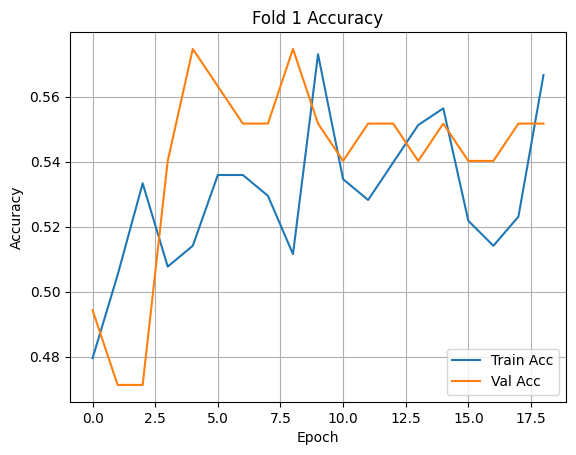

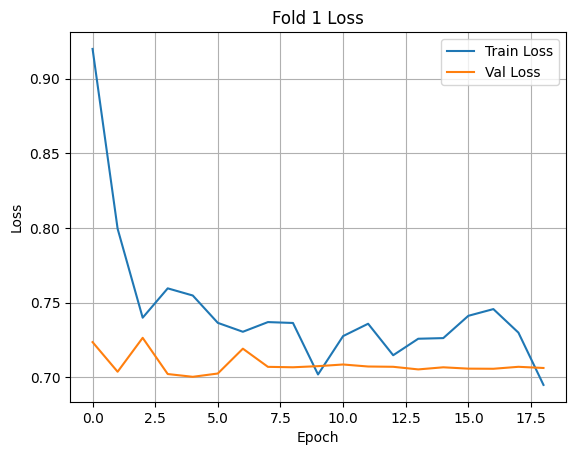

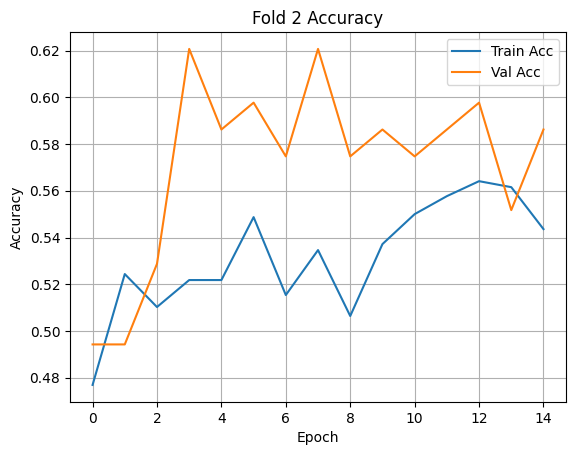

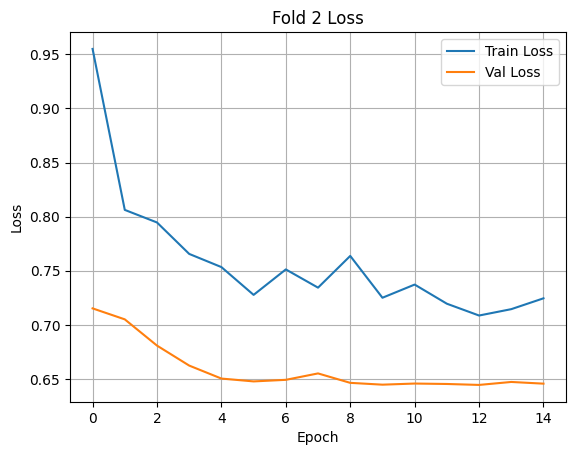

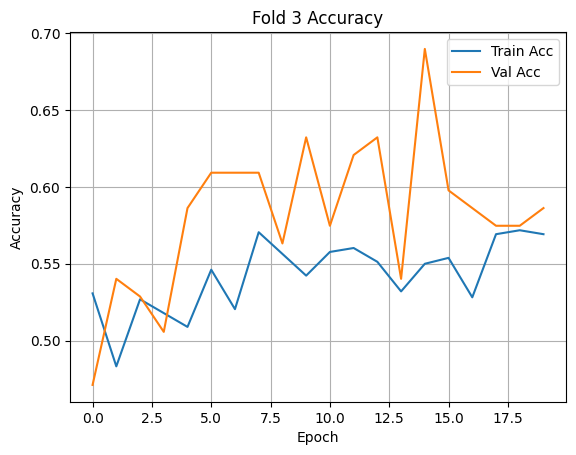

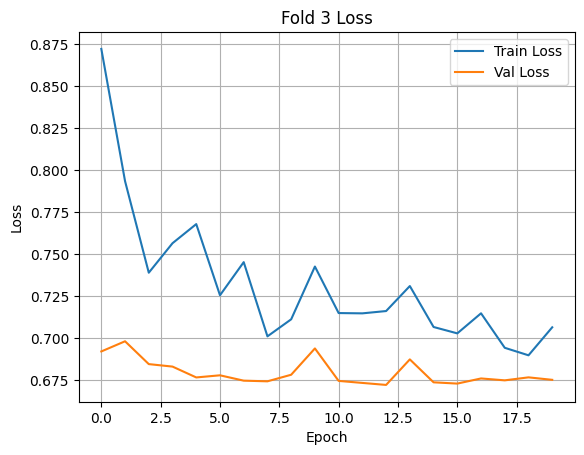

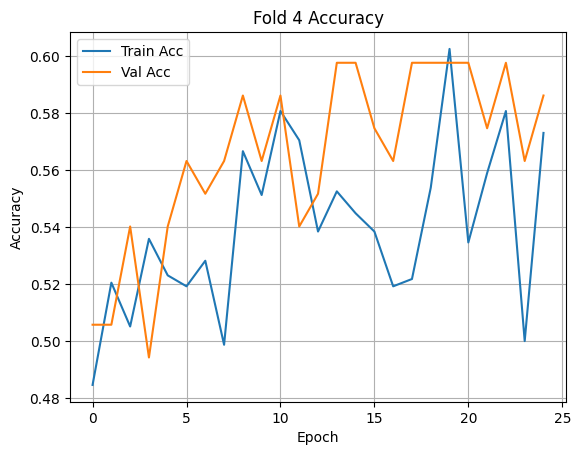

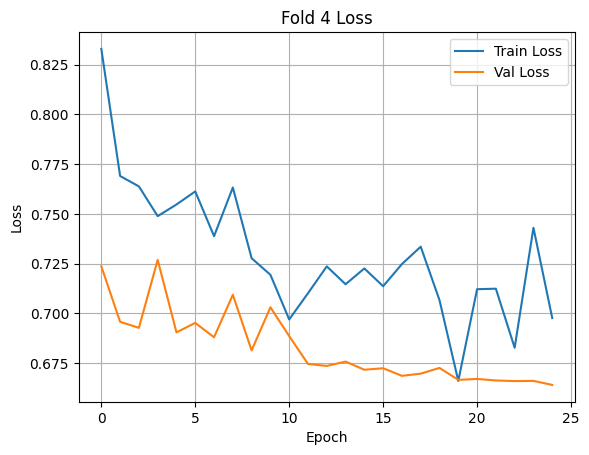

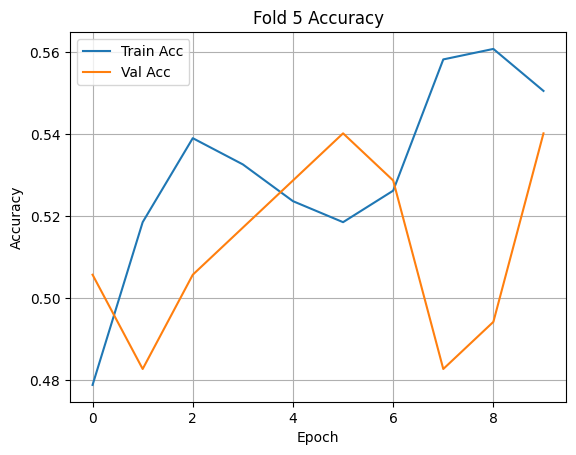

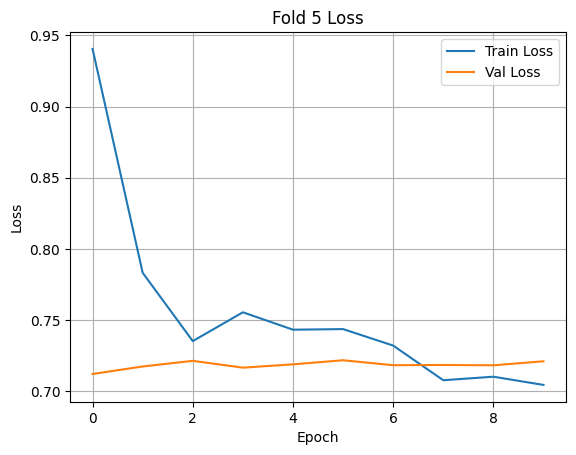

In [10]:
# =========================
# Learning curves
# =========================
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist.get('accuracy', []), label='Train Acc')
    plt.plot(hist.get('val_accuracy', []), label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.show()

    plt.figure()
    plt.plot(hist.get('loss', []), label='Train Loss')
    plt.plot(hist.get('val_loss', []), label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()

In [11]:
# Save mô hình fold cuối cùng
model.save("dct_effv2b0_transformer_attnpool_finetuned.keras")  # dùng Keras format mới

In [12]:
# =========================
# Thống kê bổ sung
# =========================
accuracy_mean = results_df['accuracy'].mean()
accuracy_std  = results_df['accuracy'].std()
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / max(accuracy_mean, 1e-8)) * 100

print("\n📊 Kết quả trung bình (lại):")
print(results_df[['accuracy','precision','recall','f1','auc']].mean())
print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

results_df



📊 Kết quả trung bình (lại):
accuracy     0.553524
precision    0.607323
recall       0.467958
f1           0.481225
auc          0.612680
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.5535
📈 Range Accuracy: 0.0829
📉 Accuracy CV% (std/mean): 6.21%


,fold,accuracy,precision,recall,f1,auc,best_thr
0,1,0.594470,0.589286,0.611111,0.600000,0.603636,0.486833
1,2,0.525346,0.553191,0.240741,0.335484,0.572035,0.637778
2,3,0.511521,0.512195,0.577982,0.543103,0.542219,0.497883
3,4,0.562212,0.548611,0.724771,0.624506,0.620031,0.443991
4,5,0.574074,0.833333,0.185185,0.303030,0.725480,0.564875
